# Chapter 7 - Unsupervised Learning

In [2]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

# Principal Components Analysis
### A simple example

In [4]:
# Read the CSV file from the .gz compressed file, specifying 'Unnamed: 0' as the index column
sp500_px = pd.read_csv('sp500_data.csv.gz', compression='gzip', index_col='Unnamed: 0')

# Display the first few rows of the DataFrame
sp500_px.head()

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.0,0.060124,-0.022100,0.0,0.0,0.018897,0.007368,0.092165,0.259140,-0.007105,...,0.0,0.0,0.34716,0.0,0.04167,0.00000,0.015564,1.75,0.1250,0.0
1993-02-01,0.0,-0.180389,0.027621,0.0,0.0,0.018889,0.018425,0.115207,-0.100775,0.063893,...,0.0,0.0,-0.23144,0.0,0.00000,-0.01041,0.007782,1.25,0.1250,0.0
1993-02-02,0.0,-0.120257,0.035900,0.0,0.0,-0.075573,0.029482,-0.023041,0.028796,-0.014192,...,0.0,0.0,-0.11572,0.0,0.00000,0.00000,-0.007792,-0.25,0.0000,0.0
1993-02-03,0.0,0.060124,-0.024857,0.0,0.0,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,...,0.0,0.0,-0.08679,0.0,0.04167,-0.04167,-0.038919,-0.50,0.0625,0.0
1993-02-04,0.0,-0.360770,-0.060757,0.0,0.0,0.113350,-0.022114,0.069862,0.000000,-0.007096,...,0.0,0.0,0.14465,0.0,-0.04166,-0.03126,-0.046711,0.00,0.0625,0.0


In [5]:
oil_px = sp500_px[['XOM', 'CVX']]
oil_px.head()

,XOM,CVX
1993-01-29,-0.016991,0.072921
1993-02-01,0.016991,0.102089
1993-02-02,0.084954,0.029168
1993-02-03,0.067964,0.058337
1993-02-04,0.034378,0.044272


In [6]:
pcs = PCA(n_components=2)  # Initialize PCA to reduce the data to 2 components
pcs.fit(oil_px)            # Fit the PCA model to the oil prices dataset (oil_px)

# Create a DataFrame to store the principal component loadings for each feature
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)  

loadings                   # Principal component loadings (weights of each original variable on each principal component)

,XOM,CVX
0,0.664711,0.747101
1,0.747101,-0.664711


**PC1** Loadings:

    XOM contributes 0.6647 to the first principal component.
    CVX contributes 0.7471 to the first principal component.

**PC2** Loadings:

    XOM contributes 0.7471 to the second principal component.
    CVX contributes -0.6647 to the second principal component.

PC1 captures the shared variance (or common pattern) between XOM and CVX, while PC2 captures the divergence or opposite trends between the two stocks. 

These loadings represent how much each variable (XOM and CVX) contributes to each principal component (PC1 and PC2). The critical point is that the **sum of the squares** of these loadings for each principal component should equal 1:

For **PC1**:


    (0.664711)^2 + (0.747101)^2 = 0.4418 + 0.5582 = 1


For **PC2**:


    (0.747101)^2 + (-0.664711)^2 = 0.5582 + 0.4418 = 1


So, it's not about the simple sum of the numbers but about the **sum of the squares**, which ensures that the components are properly normalized.


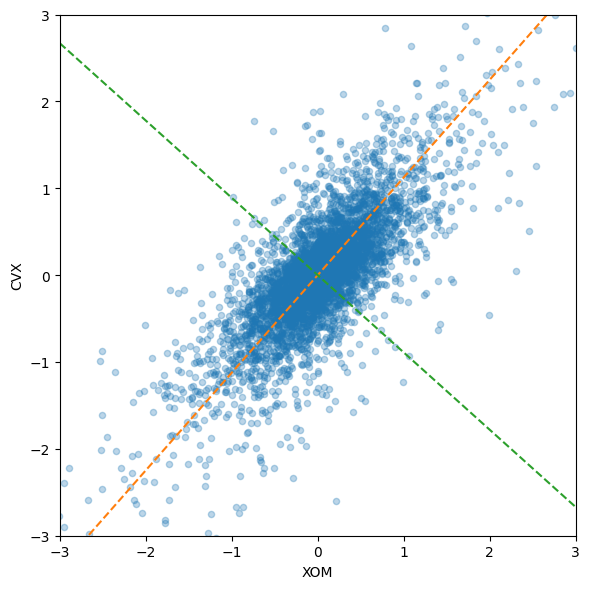

In [9]:
# Define a function that calculates a line's coordinates from slope and intercept
def abline(slope, intercept, ax):                             
    x_vals = np.array(ax.get_xlim())                          # Get the current x-axis limits from the plot and create an array of those values
    return (x_vals, intercept + slope * x_vals)               # Calculate the corresponding y values for the line using y = mx + b

# Create a scatter plot of the oil prices for 'XOM' vs 'CVX'
ax = oil_px.plot.scatter(x='XOM',                             # Plot the 'XOM' feature on the x-axis
                         y='CVX',                             # Plot the 'CVX' feature on the y-axis
                         alpha=0.3,                           # Set the transparency level of the points to 30%
                         figsize=(6, 6))                      # Set the size of the figure to 6x6 inches

ax.set_xlim(-3, 3)                                            # Set the limits of the x-axis to range from -3 to 3
ax.set_ylim(-3, 3)                                            # Set the limits of the y-axis to range from -3 to 3

# Plot the first principal component direction as a dashed line
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'],  # Calculate the slope of the first principal component (PC1)
                0,                                                # Set the intercept to 0 for this line
                ax),                                              # Provide the axis to use for plotting
        '--',                                                     # Plot the line with a dashed linestyle
        color='C1')                                               # Set the color of the line to C1 (color from matplotlib's default color cycle)

# Plot the second principal component direction as a dashed line
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'],  # Calculate the slope of the second principal component (PC2)
                0,                                                # Set the intercept to 0 for this line
                ax),                                              # Provide the axis to use for plotting
        '--',                                                     # Plot the line with a dashed linestyle
        color='C2')                                               # Set the color of the line to C2 (color from matplotlib's default color cycle)

plt.tight_layout()                                                # Adjust the plot layout to ensure that elements do not overlap
plt.show()                                                        # Display the plot

*The principal components for the stock returns for Chevron (CVX) and ExxonMobil (XOM)*

**The first principal component is essentially an average of CVX and XOM, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM diverge.**

## Interpreting Principal Components

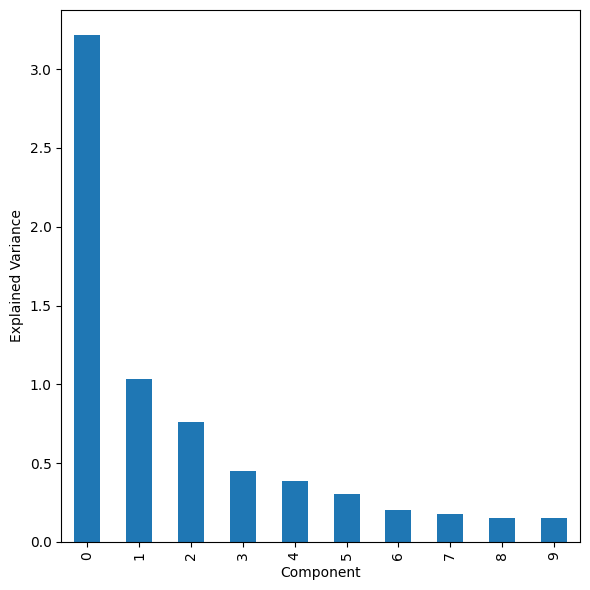

In [12]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',   # Define and sort the list of selected symbols
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])      # List represents the stock symbols of selected companies

top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]                  # Extract data for selected stocks from 2011 onwards

sp_pca = PCA()                                                               # Create an instance of PCA (Principal Component Analysis)
sp_pca.fit(top_sp)                                                           # Fit PCA on the selected data

explained_variance = pd.DataFrame(sp_pca.explained_variance_)                # Create a DataFrame for explained variance values
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(6, 6))      # Plot the first 10 components as a bar chart

ax.set_xlabel('Component')                                                   # Set x-axis label as 'Component'
ax.set_ylabel('Explained Variance')     

plt.tight_layout()                                                           # Adjust layout to prevent overlapping elements
plt.show()                                                                   # Display the plot

The bar chart above shows the explained variance for the first ten principal components after performing Principal Component Analysis (PCA) on the stock price data.

* The first principal component (PC1) explains a significantly larger amount of variance compared to all other components, which is around 3.21.

* The second component (PC2) explains about 1.03 units of variance, which is much lower compared to the first.

* The third component (PC3) explains about 0.76 unit of variance.

Since the majority of the variance is captured by the first 2-3 components, we could potentially reduce the dataset to these components without losing much information.

In [14]:
explained_variance

,0
0,3.214705
1,1.036612
2,0.758945
3,0.449148
4,0.383932
5,0.300768
6,0.205285
7,0.174577
8,0.152261
9,0.150546


In [15]:
# Rename column 0 to 'explain_var'
explained_variance.rename(columns={0: 'explain_var'}, inplace=True)

# Calculate the total variance
total_var = explained_variance['explain_var'].sum()

# Calculate the percentage of variance explained by each component
explained_variance['percentage'] = explained_variance['explain_var'] / total_var

# Calculate the cumulative percentage
explained_variance['cumulative_%'] = explained_variance['percentage'].cumsum()

# Display the updated DataFrame
explained_variance

,explain_var,percentage,cumulative_%
0,3.214705,0.444838,0.444838
1,1.036612,0.143442,0.588280
2,0.758945,0.105020,0.693299
3,0.449148,0.062151,0.755451
4,0.383932,0.053127,0.808578
5,0.300768,0.041619,0.850197
6,0.205285,0.028407,0.878603
7,0.174577,0.024157,0.902760
8,0.152261,0.021069,0.923830
9,0.150546,0.020832,0.944662


Let's work with the first 5 principal components:

In [17]:
# Create a DataFrame for the loadings of the first 5 principal components
loadings2 = pd.DataFrame(sp_pca.components_[0:5, :],  # Extract loadings for the first 5 principal components
                         columns=top_sp.columns)      # Use the column names from 'top_sp' to label the features
loadings2

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
0,0.300825,0.246332,0.261529,0.273634,0.064059,0.444490,0.207983,0.076956,0.196397,0.105012,0.481786,0.148833,0.116421,0.145684,0.122304,0.317952
1,0.505116,0.139426,-0.174212,0.416307,0.031939,-0.289373,0.278002,0.033898,0.040723,0.053954,-0.472494,0.228123,0.054796,0.047427,0.222889,-0.154192
2,0.786730,-0.135458,0.002367,-0.465862,0.007524,-0.082374,-0.166320,0.003518,-0.062261,-0.016248,0.194822,-0.160833,-0.048976,-0.041932,-0.175806,-0.090167
3,-0.120586,0.061814,-0.206026,0.092596,0.003904,-0.577665,0.162814,-0.001605,0.057687,-0.012558,0.680914,0.109895,0.016752,0.018614,0.058439,-0.295204
4,-0.111576,0.596666,0.005813,-0.555529,0.039860,-0.109016,0.185488,0.072047,0.385160,0.077135,-0.181332,0.055557,0.155440,0.216425,-0.091541,-0.013277


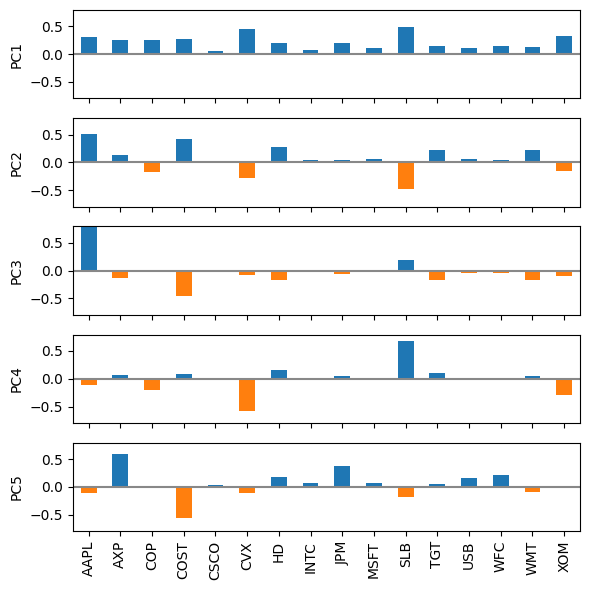

In [18]:
# Determine the maximum value for setting consistent y-axis limits, scaling by 1.01 for buffer
maxPC = 1.01 * loadings2.loc[0:5, :].abs().to_numpy().max()  

f, axes = plt.subplots(5, 1, figsize=(6, 6), sharex=True)  # Create 5 vertically stacked subplots, sharing the x-axis

# Loop over each principal component and its respective subplot
for i, ax in enumerate(axes):                              
    pc_loadings = loadings2.loc[i, :]                        # Get the loadings for the current principal component
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]  # Set bar colors: 'C0' for positive, 'C1' for negative values
    ax.axhline(color='#888888')                              # Draw a horizontal line at y=0 for reference
    pc_loadings.plot.bar(ax=ax, color=colors)                # Plot the bar chart of loadings for the current principal component
    ax.set_ylabel(f'PC{i+1}')                                # Label the y-axis with the principal component number
    ax.set_ylim(-maxPC, maxPC)                               # Set consistent y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to minimize overlap and improve visual presentation
plt.show()          # Display the plot

This graph shows the loadings of the first five Principal Components (PC1 to PC5) for different stocks. The stocks are represented along the x-axis, and the bars indicate the weight (loading) of each stock in the corresponding principal component.

#### Insights from the Graph:

PC1:

* The first principal component (PC1) has moderate positive loadings for many stocks. This suggests that PC1 represents a common factor that affects most of these stocks in a similar way.
Notably, AAPL, HD, and XOM have relatively higher positive contributions compared to others.

PC2:

* PC2 has both positive and negative loadings. Stocks such as AAPL and JPM have significant positive loadings, while CVX and XOM have significant negative loadings.
This suggests that PC2 might capture contrasting behaviors between groups of stocks, indicating diversification or opposing trends.

PC3:

* PC3 also has both positive and negative loadings, with AAPL having a strong positive contribution, while a significant number of stocks (e.g., COST, WMT, WFC) have negative loadings.
This indicates that PC3 might represent a factor that has a different impact on specific stocks, possibly reflecting different sectors' behavior or individual company performance.

PC4:

* In PC4, JPM has a very prominent positive loading, whereas COP and XOM have negative contributions.
The prominence of JPM might indicate that PC4 is influenced heavily by financial sector trends or events affecting banking stocks.

PC5:

* PC5 shows a mix of moderate positive and negative loadings across different stocks. Notably, AXP and JPM show relatively high positive contributions, while XOM has a negative contribution.
This principal component might be capturing more specific, nuanced market behaviors that impact different sectors in distinct ways.

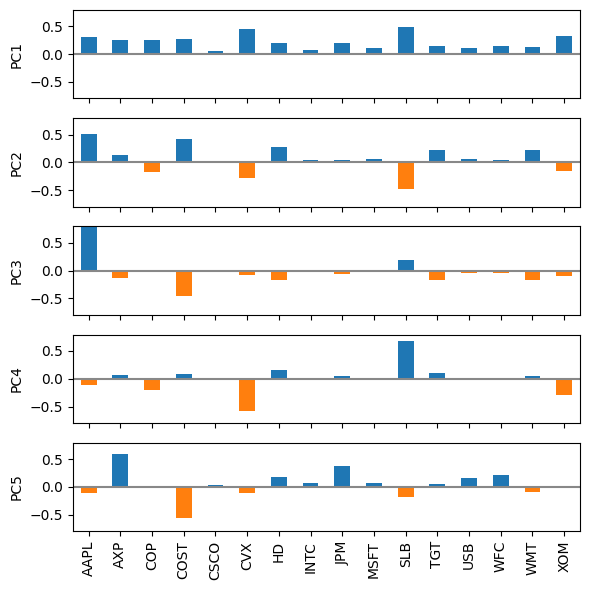

In [20]:
# Plotting Again

# Determine the maximum value for setting consistent y-axis limits, scaling by 1.01 for buffer
maxPC = 1.01 * loadings2.loc[0:5, :].abs().to_numpy().max()  

f, axes = plt.subplots(5, 1, figsize=(6, 6), sharex=True)  # Create 5 vertically stacked subplots, sharing the x-axis

# Loop over each principal component and its respective subplot
for i, ax in enumerate(axes):                              
    pc_loadings = loadings2.loc[i, :]                        # Get the loadings for the current principal component
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]  # Set bar colors: 'C0' for positive, 'C1' for negative values
    ax.axhline(color='#888888')                              # Draw a horizontal line at y=0 for reference
    pc_loadings.plot.bar(ax=ax, color=colors)                # Plot the bar chart of loadings for the current principal component
    ax.set_ylabel(f'PC{i+1}')                                # Label the y-axis with the principal component number
    ax.set_ylim(-maxPC, maxPC)                               # Set consistent y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to minimize overlap and improve visual presentation
plt.show()          # Display the plot

#### General Interpretation:
**Variation in Loadings:** The positive and negative loadings indicate that the components are trying to capture different aspects of the data. Components with both high positive and negative loadings (like PC2, PC3, PC4) are likely capturing different behaviors or groupings of stocks, such as sector-specific effects or opposing trends.

**Sector Trends:** The loadings show that certain stocks, particularly those in the same sector, may have similar or opposing impacts on each principal component. For example, oil companies like CVX and XOM often have similar behavior in terms of loadings.

**Dimensionality Reduction:** The purpose of PCA is to reduce the dimensionality of the data. The fact that only a few components (e.g., PC1 and PC2) have significant loadings suggests that these components capture most of the variance in the data, which helps summarize the information effectively.

For instance, in the graph, if you see that XOM and CVX have similar loadings on multiple components, it suggests that these two oil companies share similar price movement behavior — i.e., they are likely correlated.

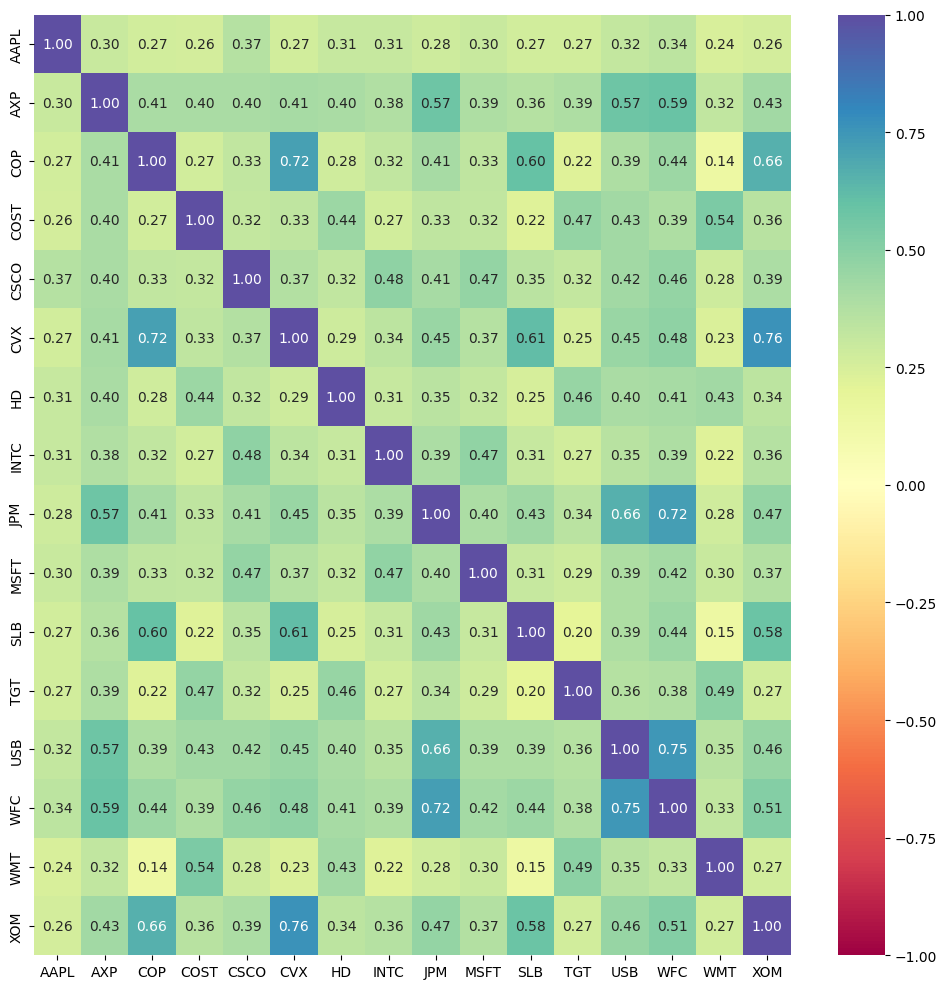

In [22]:
from seaborn import heatmap

# Compute the correlation matrix for the DataFrame 'top_sp'
correlation_matrix = top_sp.corr()

# Create a figure and axis with dimensions 6x6 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a heatmap to display the correlation matrix of selected stocks
ax = heatmap(
    correlation_matrix,                # Use the computed correlation matrix for the heatmap
    fmt=".2f",                         # Format the annotation text to 2 decimal places
    annot=True,                        # Annotate each cell in the heatmap with its correlation value
    ax=ax,                             # Use the specified axis for the plot
    cmap="Spectral",                   # Set the color palette to 'Spectral'
    vmin=-1,                           # Set the minimum value of the color scale to -1 (strong negative correlation)
    vmax=1                             # Set the maximum value of the color scale to 1 (strong positive correlation)
)

plt.tight_layout()  # Adjust layout to minimize overlap and improve visual presentation
plt.show()          # Display the heatmap

## Correspondence Analysis

PCA cannot be used for categorical data; however, a somewhat related technique is
correspondence analysis. The goal is to recognize associations between categories, or
between categorical features. The similarities between correspondence analysis and
principal components analysis are mainly under the hood—the matrix algebra for
dimension scaling. Correspondence analysis is used mainly for graphical analysis of
low-dimensional categorical data and is not used in the same way that PCA is for
dimension reduction as a preparatory step with big data.

In [25]:
url1 = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/housetasks.csv'
housetasks = pd.read_csv(url1, index_col=0)
housetasks

,Wife,Alternating,Husband,Jointly
Task,,,,
Laundry,156,14,2,4
Main_meal,124,20,5,4
Dinner,77,11,7,13
Breakfast,82,36,15,7
Tidying,53,11,1,57
Dishes,32,24,4,53
Shopping,33,23,9,55
Official,12,46,23,15
Driving,10,51,75,3


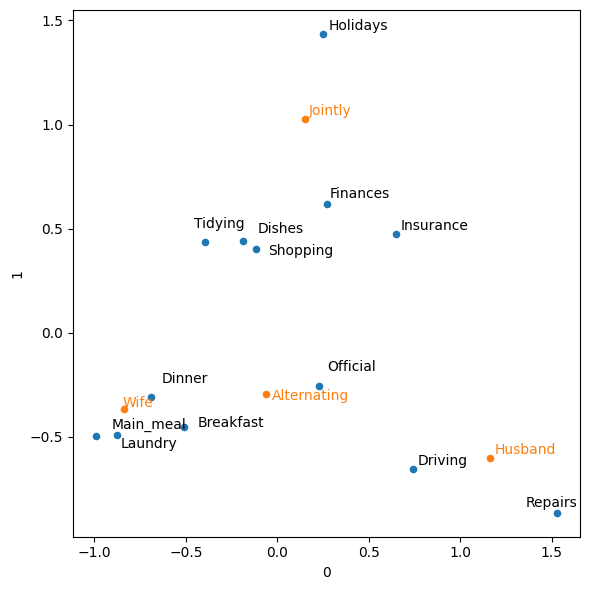

In [26]:
from adjustText import adjust_text

# Fit a Correspondence Analysis (CA) model to the data
ca = prince.CA(n_components=2)  # Initialize CA model with 2 components
ca = ca.fit(housetasks)         # Fit the CA model to the 'housetasks' data

# Plot the row coordinates from the CA analysis
ax = ca.row_coordinates(housetasks).plot.scatter(
    x=0,                        # Use the first component as x-axis
    y=1,                        # Use the second component as y-axis
    figsize=(6,6)               # Set the figure size to 6x6 inches
)

# Overlay the column coordinates from the CA analysis on the same plot
ca.column_coordinates(housetasks).plot.scatter(
    x=0,                        # Use the first component as x-axis
    y=1,                        # Use the second component as y-axis
    ax=ax,                      # Plot on the same axis as row coordinates
    c='C1'                      # Use a different color ('C1') for column points
)

texts = []  # Initialize an empty list to store text labels

# Add text labels for each row coordinate on the plot
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(
        row[0],                 # x-coordinate for the text
        row[1],                 # y-coordinate for the text
        idx                     # Label text as the row index
    ))

# Add text labels for each column coordinate on the plot
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(
        row[0],                 # x-coordinate for the text
        row[1],                 # y-coordinate for the text
        idx,                    # Label text as the column index
        color='C1'              # Set label color to 'C1' to match column points
    ))

# Adjust the position of the text labels to avoid overlap
adjust_text(
    texts,                      # Pass the list of text objects to adjust
    only_move={'points': 'y', 'texts': 'y'}  # Move only in y-direction
) 

plt.tight_layout()  # Adjust the layout to minimize overlap between elements
plt.show()          # Display the plot

#### Points Represent Relationships:

**Blue Points:** These represent different types of household tasks (e.g., "Holidays," "Laundry," "Shopping").

**Orange Points:** These represent different categories indicating who does the task (e.g., "Jointly," "Wife," "Husband," "Alternating").

#### Proximity Matters:

Points that are closer to each other are more related, meaning they are often associated together.

* For example, the blue point "Repairs" is close to the orange point "Husband." This suggests that "Repairs" are typically done by the Husband.
* The blue points "Main_meal," "Laundry," and "Dinner" are closer to "Wife" indicating these tasks are often performed by the Wife.

#### Tasks Done Together:

* The orange point "Jointly" is positioned close to "Holidays," suggesting that holidays are often managed jointly. 
* Similarly, "Shopping," "Dishes," and "Tidying" are positioned near each other and moderately close to "Jointly", indicating that these tasks might often be shared responsibilities.

#### Distinct Categories:

* The point "Driving" is positioned near "Husband," while "Insurance" and "Finances" are somewhat neutral but slightly leaning towards being managed jointly.
* "Alternating" appears in the middle, not too close to any specific tasks, suggesting that tasks associated with "Alternating" are more evenly spread across the various household responsibilities without a dominant task.

# K-Means Clustering

Clustering is a technique to divide data into different groups, where the records ineach group are similar to one another. A goal of clustering is to identify significantand meaningful groups of data. The groups can be used directly, analyzed in moredepth, or passed as a feature or an outcome to a predictive regression or classificationmodel. K-means was the first clustering method to be developed; it is still widelyused, owing its popularity to the relative simplicity of the algorithm and its ability toscale to large data sets.

### A Simple Example

In [29]:
# Extract data for two stocks (XOM and CVX) from the SP500 dataset starting from 2011
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]

# Apply KMeans clustering to the extracted data
kmeans = KMeans(n_clusters=4, n_init='auto').fit(df)  # Initialize and fit KMeans with 4 clusters and automatic initialization setting

# Assign the cluster labels to a new column in the DataFrame
df['cluster'] = kmeans.labels_

# Display the first 5 rows
df.head()

,XOM,CVX,cluster
2011-01-03,0.736805,0.240681,1
2011-01-04,0.168668,-0.584516,2
2011-01-05,0.026631,0.446985,1
2011-01-06,0.248558,-0.919751,2
2011-01-07,0.337329,0.180511,1


As the K-means algorithm uses randomized starting points, the results may differ
between subsequent runs and different implementations of the method. In general,
you should check that the fluctuations aren’t too large.

In [31]:
# Create a DataFrame containing the coordinates of the cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])

# Print the cluster centers to see their coordinates
print(centers)

        XOM       CVX
0 -1.097628 -1.691203
1  0.330589  0.461518
2 -0.275103 -0.473619
3  1.101573  1.581232


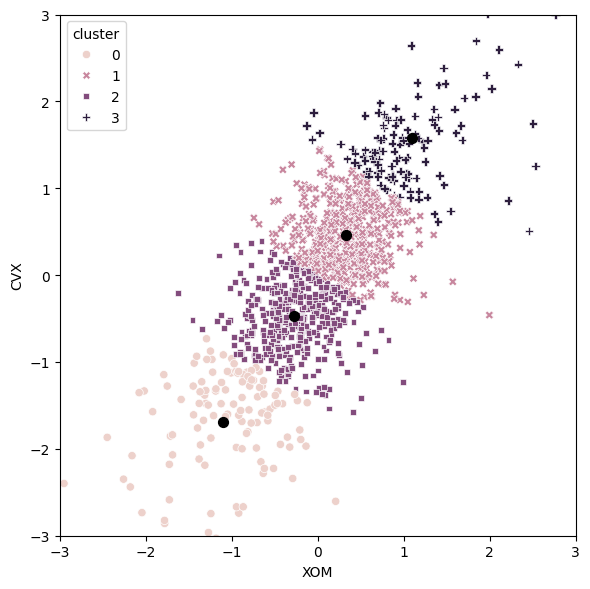

In [32]:
fig, ax = plt.subplots(figsize=(6, 6)) # Create a figure and axis

# Plot a scatterplot of XOM and CVX with color and style representing clusters
ax = sns.scatterplot(x='XOM',                          # X-axis values are the XOM stock prices
                     y='CVX',                          # Y-axis values are the CVX stock prices
                     hue='cluster',                    # Color each point based on the cluster label
                     style='cluster',                  # Style each point (shape) based on the cluster label
                     ax=ax,                            # Use the axis created earlier
                     data=df)                          # Data to be used for the scatter plot

ax.set_xlim(-3, 3)                                     # Set x-axis limits
ax.set_ylim(-3, 3)                                     # Set y-axis limits

# Plot the cluster centers as black points to show their locations on the scatter plot
centers.plot.scatter(x='XOM',                          # X-axis values for cluster centers are the XOM coordinates
                     y='CVX',                          # Y-axis values for cluster centers are the CVX coordinates
                     ax=ax,                            # Use the existing axis to add the cluster centers
                     s=50,                             # Set the size of the marker
                     color='black')                    # Set the color of the cluster centers to black

plt.tight_layout() # Adjust layout to avoid overlap and ensure all elements fit well within the plot
plt.show()         # Display the scatter plot

## K-Means Algorithm

In [34]:
# Define and sort the list of selected symbols (tickers of companies)
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])

# Extract data for selected stocks from 2011 onwards
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5,                # 5 clusters                
                random_state=42,             # For tracking graphic comments
                n_init='auto').fit(top_sp)   # Set n_init to 'auto' to automatically determine the number of initializations

## Interpreting the Clusters

In [36]:
from collections import Counter  # Import the Counter class from the collections module

print(Counter(kmeans.labels_))   # Count the frequency of each cluster label in the KMeans result

Counter({3: 314, 2: 306, 4: 280, 0: 119, 1: 112})


The cluster sizes are relatively balanced. Imbalanced clusters can result from distant
outliers, or from groups of records very distinct from the rest of the data—both may
warrant further inspection.

In [38]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)
centers

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
0,0.590773,0.706372,0.759427,0.865773,0.188415,1.345483,0.668010,0.236759,0.568816,0.326410,1.488527,0.439136,0.375131,0.427607,0.434804,0.987947
1,-1.214310,-0.989612,-0.867155,-1.068486,-0.219674,-1.396155,-0.737076,-0.293013,-0.784938,-0.390878,-1.423913,-0.614538,-0.432390,-0.547939,-0.401639,-1.001222
2,-0.414208,-0.193546,-0.353344,-0.117845,-0.062964,-0.569998,-0.134735,-0.050345,-0.129556,-0.079101,-0.745006,-0.076818,-0.070155,-0.114508,-0.040815,-0.356942
3,0.666562,0.300979,0.069382,0.434608,0.077830,0.106818,0.387228,0.099228,0.160107,0.122805,0.004939,0.316802,0.113016,0.135329,0.259020,0.129492
4,-0.240400,0.040269,0.272453,-0.214841,0.032661,0.472437,-0.140290,0.039329,0.081573,0.031853,0.627004,-0.179031,0.014689,0.051259,-0.132286,0.347067


    Each column represents an axis in a 16-dimensional space where each stock is a different dimension.
    
    Cluster centers are coordinates in this space and describe the average position of all points (stocks) belonging to that cluster.

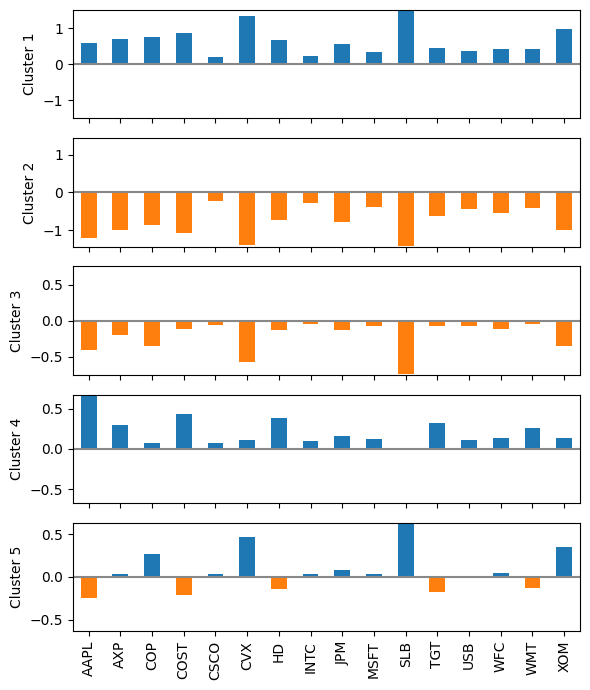

In [40]:
f, axes = plt.subplots(5, 1, figsize=(6, 7), sharex=True)  # Create 5 vertically stacked subplots with shared x-axis and specified figure size

# Loop through each cluster center to create individual bar plots
for i, ax in enumerate(axes):                              
    center = centers.loc[i, :]                             # Get the values for the current cluster center
    maxPC = 1.01 * np.max(np.max(np.abs(center)))          # Determine maximum value for consistent y-axis limits, adding 1% buffer
    colors = ['C0' if l > 0 else 'C1' for l in center]     # Assign color: 'C0' for positive, 'C1' for negative values
    ax.axhline(color='#888888')                            # Draw a horizontal reference line at y=0
    center.plot.bar(ax=ax, color=colors)                   # Plot the cluster center values as a bar chart, colored by sign
    ax.set_ylabel(f'Cluster {i + 1}')                      # Label y-axis with the cluster number
    ax.set_ylim(-maxPC, maxPC)                             # Set consistent y-axis limits for all subplots

plt.tight_layout()  # Adjust layout to minimize overlap and ensure proper display
plt.show()          # Display the plots

The resulting plot reveals the nature of each cluster. For example: 

* Clusters 1 and 4 correspond to days on which the market is up;
* Clusters 2 and 3 correspond to days on which the market is down;* Cluster 5 captures the days in which energy stocks were up and consumer stocks were down.

## Selecting the Number of Clusters

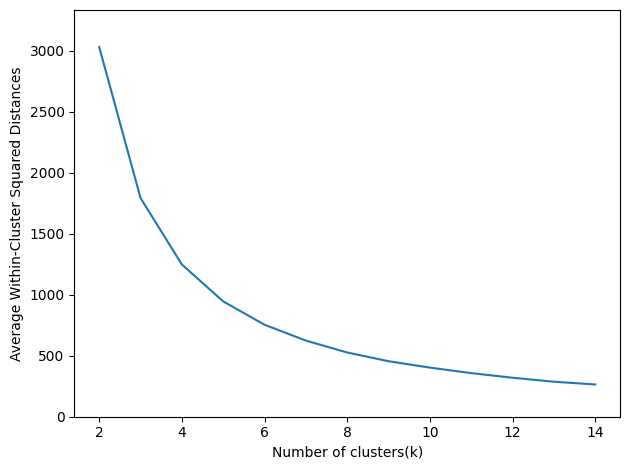

In [43]:
inertia = []  # Initialize an empty list to store inertia values for different numbers of clusters

# Loop through a range of cluster numbers from 2 to 14 to evaluate clustering performance
for n_clusters in range(2, 15):  
    kmeans = KMeans(n_clusters=n_clusters,            # Set the number of clusters for KMeans
                    random_state=0,                   # Use a fixed random seed for reproducibility
                    n_init='auto').fit(top_sp)        # Fit the KMeans model to the dataset
    inertia.append(kmeans.inertia_ / n_clusters)      # Calculate the average inertia for each cluster and store in the list

# Create a DataFrame to store number of clusters and corresponding inertia values
inertias = pd.DataFrame({'n_clusters': range(2, 15),  # The number of clusters
                         'inertia': inertia})         # The inertia value for each number of clusters

# Plot inertia values against the number of clusters to visualize the elbow curve
ax = inertias.plot(x='n_clusters',                    # Plot x-axis as the number of clusters
                   y='inertia')                       # Plot y-axis as the inertia value

# Set plot labels
plt.xlabel('Number of clusters(k)')                   # Set label for x-axis
plt.ylabel('Average Within-Cluster Squared Distances')  # Set label for y-axis
plt.ylim((0, 1.1 * inertias.inertia.max()))           # Set the y-axis limits to give some buffer above the max value
ax.legend().set_visible(False)                        # Hide the legend for better visual clarity

plt.tight_layout()  # Adjust layout to avoid overlapping elements
plt.show()          # Display the plot

The elbow method helps determine the optimal number of clusters by looking for the "elbow" point where the within-cluster distances (inertia) start to decrease more slowly. Essentially, it's the point where the graph changes from steep to less steep, forming an elbow-like bend.

The point at 4 clusters seems to be the "elbow" where the rate of reduction in inertia significantly diminishes. This indicates that adding more clusters beyond this point provides diminishing returns in terms of reducing the average within-cluster distance. 4 clusters would likely be a good choice for balancing the complexity of the model and the quality of clustering.

# Hierarchical Clustering
Hierarchical clustering is an alternative to K-means that can yield very different clusters. Hierarchical clustering allows the user to visualize the effect of specifying different numbers of clusters. It is more sensitive in discovering outlying or aberrant
groups or records. Hierarchical clustering also lends itself to an intuitive graphical
display, leading to easier interpretation of the clusters.

In [46]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD',  # Define a list of selected stock symbols
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']     # These symbols represent different companies

# Filter data for the selected symbols from 2011 onwards and transpose the DataFrame
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

df.head(10)  # Display the first 10 rows

,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-10,2011-01-11,2011-01-12,2011-01-13,2011-01-14,...,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01
AAPL,0.527368,-0.154321,0.597152,-0.132850,0.285820,0.485766,-0.434780,0.157012,0.069781,0.347552,...,0.649994,-1.110001,0.120003,-0.450004,0.900002,-1.360001,-0.919998,-0.930000,-0.140000,-0.300004
AMZN,2.850006,-1.139999,3.319992,-0.639999,-2.390000,-0.360000,-1.080002,-1.279999,1.929993,3.250000,...,9.090027,-5.339997,-0.709991,10.399994,-4.130005,2.029999,-3.660004,-5.120026,-0.110016,-1.959991
AXP,0.093870,-0.431788,0.895406,-0.612646,-0.537242,0.245056,0.056553,-0.414713,0.235633,1.244141,...,0.528023,-0.328765,0.567875,-0.079703,-0.199258,-1.105863,-0.288920,-1.414705,-0.449997,-0.239997
COP,-0.336272,-0.463161,-0.057104,-0.463161,-0.006350,0.095172,0.380682,0.038061,-0.704260,0.279170,...,-0.220002,-0.200001,0.100002,0.489998,-0.299999,-0.949997,0.029998,-0.410000,-0.119999,-1.479999
COST,-0.240605,-0.171859,-0.859307,0.249200,-0.257788,0.171865,0.446837,0.249200,0.240604,0.996799,...,1.009995,-0.289993,-0.649994,-0.790008,-1.000000,-1.000000,0.119996,-1.319993,-1.320007,0.700012
CSCO,0.035704,0.008926,0.169599,0.035706,0.098187,-0.133894,-0.017853,0.107116,-0.089263,0.071410,...,0.357246,-0.208393,-0.158775,-0.208393,-0.277860,-0.158775,-0.208393,-0.446558,-0.367171,-0.070000
CVX,0.240681,-0.584516,0.446985,-0.919751,0.180511,-0.464168,0.825197,0.077359,0.146127,0.610301,...,-0.010002,-0.250000,0.459999,0.129997,-0.710006,-1.110001,0.360000,-0.809998,-0.979996,-0.210007
GOOGL,3.938934,-1.751740,4.504517,1.411408,0.265259,-0.295288,-0.850830,-1.241242,-0.140137,3.393402,...,8.179993,1.000000,0.270020,3.600037,-3.909973,-2.349976,-6.650024,-5.500000,-5.050049,-0.359985
HD,0.099184,-0.541005,-0.054099,-0.189354,-0.036064,0.207384,0.225418,0.027053,0.414769,0.703303,...,0.790000,0.790001,0.140000,-0.059998,-0.590004,-1.000000,-0.169999,-1.019997,-0.020005,-0.379997
INTC,-0.137211,0.025726,-0.214392,0.085757,-0.042878,-0.017150,0.188664,0.025726,0.025728,-0.231544,...,0.299999,-0.330002,0.000000,-0.220001,-0.240002,-0.030000,-0.490000,-0.310002,-0.209999,-0.310000


In [47]:
Z = linkage(df, method='complete')  # Perform hierarchical clustering using the 'complete' linkage method

print(Z.shape)                      # Print the shape of the linkage matrix

(17, 4)


## The Dendrogram

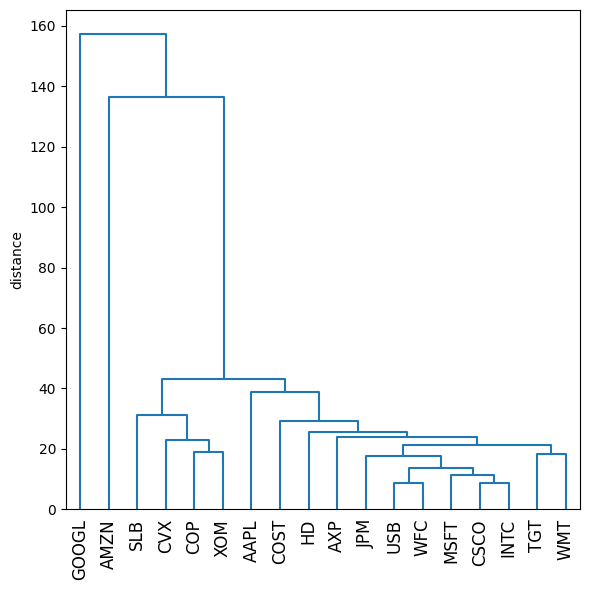

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and an axis with a size of 6x6 inches

# Plot a dendrogram based on the linkage matrix Z with stock symbols as labels
dendrogram(Z, labels=list(df.index), color_threshold=0, ax=ax)  

plt.xticks(rotation=90)                 # Rotate x-axis labels by 90 degrees for better visibility
ax.set_ylabel('distance')               # Set the y-axis label as 'distance' to indicate the clustering distances

plt.tight_layout()                      # Adjust the layout to avoid overlapping elements
plt.show()                              # Display the dendrogram

#### General Observation

The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters. The returns for Google and Amazon are quite dissimilar to one another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM, COP) are in their own cluster, Apple (AAPL) is by itself, and the rest are similar to one another.

#### Some Insights

* TGT and WMT are merged at a very low distance, suggesting these stocks have had similar movements, likely due to them both being large retail companies.

* GOOGL and AMZN are merged at a relatively high distance compared to others, indicating these stocks are quite different from the rest, likely due to their unique business models (tech and e-commerce focus).

* SLB (Schlumberger, an oilfield services company) is also grouped separately with GOOGL and AMZN, showing that these stocks have distinct price movement behaviors compared to the others.

In [51]:
memb = fcluster(Z, 4, criterion='maxclust')   # Form flat clusters from hierarchical clustering linkage, creating 4 clusters in total
memb = pd.Series(memb, index=df.index)        # Convert the cluster membership to a Pandas Series with the stock symbols as the index

# Loop through each cluster, grouping the stocks by their assigned cluster, and print them
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")  # Print the cluster number and the stock symbols belonging to that cluster

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


This clustering information can be used for portfolio diversification. If you want to minimize risk, you would choose stocks from different clusters, as they are less likely to be correlated.

It also provides insights into the relationship between companies based on stock price behavior, which may relate to similar sectors, market influences, or other economic factors.

# Measures of Dissimilarity

There are four common measures of dissimilarity: single linkage, average linkage, complete linkage, and minimum variance (Ward).

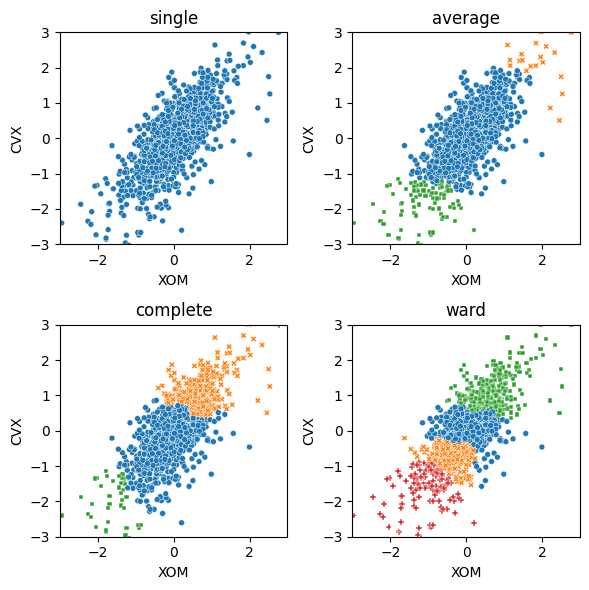

In [55]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]       # Extract data for 'XOM' and 'CVX' stocks from 2011 onwards

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))              # Create a figure with a 2x2 grid of subplots

# Loop through four different linkage methods and create a scatter plot for each
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]                                            # Select the appropriate subplot
    Z = linkage(df, method=method)                                      # Perform hierarchical clustering using the given method
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]  # Assign colors to points based on their cluster membership
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,    # Create a scatter plot with points colored and styled by cluster
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)     # Set x-axis limits
    ax.set_ylim(-3, 3)     # Set y-axis limits
    ax.set_title(method)   # Set the title of the subplot to the clustering method used

plt.tight_layout()         # Adjust layout to ensure subplots are properly spaced and no overlapping
plt.show()                 # Display the plots

*A comparison of measures of dissimilarity applied to stock data*

# Model-Based Clustering
Clustering methods such as hierarchical clustering and K-means are based on heuristics and rely primarily on finding clusters whose members are close to one another, as measured directly with the data (no probability model involved). 

## Multivariate Normal Distribution
The most widely used model-based clustering methods rest on the multivariate nomal distribution. The multivariate normal distribution is a generalization of the nomal distribution to a set of p variables X1, X2, ..., Xp. 

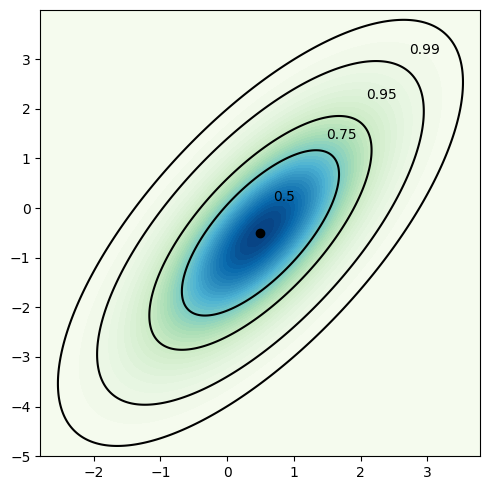

In [58]:
mean = [0.5, -0.5]                            # Define the mean for the bivariate normal distribution
cov = [[1, 1], [1, 2]]                        # Define the covariance matrix for the distribution
probability = [.5, .75, .95, .99]             # Define probability levels for contour lines

def probLevel(p):
    D = 1                                     # D is the determinant of the covariance matrix (here, set to 1)
    return (1 - p) / (2 * math.pi * D)        # Calculate probability level based on input probability 'p'
    
levels = [probLevel(p) for p in probability]  # Generate contour levels based on the specified probabilities

fig, ax = plt.subplots(figsize=(5, 5))        # Create a figure and an axis for the plot

# Generate a grid of x and y coordinates within a given range
x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))                # Create an empty array to hold the coordinates for the 2D grid
pos[:, :, 0] = x; pos[:, :, 1] = y            # Assign x and y values to the coordinate grid

rv = multivariate_normal(mean, cov)           # Create a multivariate normal distribution with the specified mean and covariance

CS = ax.contourf(x,                           # Create a filled contour plot of the PDF of the bivariate normal
                 y, 
                 rv.pdf(pos), 
                 cmap=cm.GnBu,                # Use the 'GnBu' colormap for the filled contour plot
                 levels=50)                   # Use 50 levels to create smoother contours

ax.contour(CS,                                # Add contour lines to the filled plot for specified probability levels
           levels=levels, 
           colors=['black'])                  

# Plot the mean of the distribution as a point on the plot
ax.plot(*mean,                                
        color='black', 
        marker='o')

# Legend made manually
ax.annotate('0.5', xy=(0.58, 0.58), xycoords='axes fraction', fontsize=10, ha='right', va='center')
ax.annotate('0.75', xy=(0.72, 0.72), xycoords='axes fraction', fontsize=10, ha='right', va='center')
ax.annotate('0.95', xy=(0.81, 0.81), xycoords='axes fraction', fontsize=10, ha='right', va='center')
ax.annotate('0.99', xy=(0.91, 0.91), xycoords='axes fraction', fontsize=10, ha='right', va='center')

plt.tight_layout()                            # Adjust the layout to prevent any overlap or clipping
plt.show()                                    # Display the plot

*Probability contours for a two-dimensional normal distribution*

## Mixtures of Normals

The key idea behind model-based clustering is that each record is assumed to be distributed as one of K multivariate normal distributions, where K is the number of clusters.

In [62]:
# Extract data for stocks 'XOM' and 'CVX' from 2011 onwards
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]  

# Fit a Gaussian Mixture model with 2 components to the data
mclust = GaussianMixture(n_components=2).fit(df)  

# Calculate and return the Bayesian Information Criterion (BIC) for the model on the dataset
mclust.bic(df)  

4589.3203170532615

The BIC helps you assess how well the Gaussian mixture model fits the stock data with a specific number of clusters, balancing goodness of fit with model complexity. A lower BIC value is preferred as it implies a better fit with fewer unnecessary parameters.

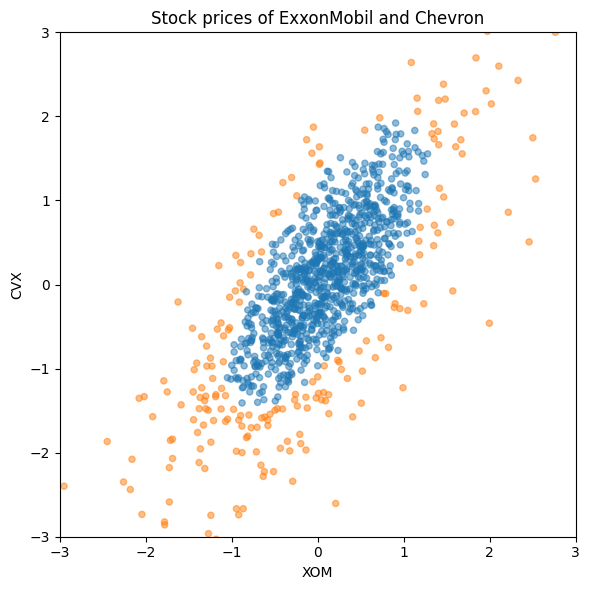

In [64]:
fig, ax = plt.subplots(figsize=(6, 6))          # Create a figure and axis for plotting with a size of 6x6 inches

colors = [f'C{c}' for c in mclust.predict(df)]  # Generate color labels based on the cluster predicted by GaussianMixture

# Plot a scatter plot of 'XOM' vs 'CVX' using the color labels assigned by the clustering model
df.plot.scatter(x='XOM', 
                y='CVX', 
                c=colors,                       # Color the points based on the cluster they belong to
                alpha=0.5,                      # Set transparency to make overlapping points clearer
                ax=ax)                          # Use the created axis for the plot

ax.set_xlim(-3, 3)  # Set x-axis limits
ax.set_ylim(-3, 3)  # Set y-axis limits
plt.title('Stock prices of ExxonMobil and Chevron')  # Set title for the plot

plt.tight_layout()  # Adjust the layout to make sure all components fit well
plt.show()          # Display the plot

The Gaussian Mixture Model aims to identify different "underlying groups" in the data based on similarities. This provide insights that can be useful for portfolio risk management or to develop trading strategies that exploit moments of divergence between correlated stocks.

#### Specific Insights

The orange cluster represents data points that are tightly packed and follow a central trend. This indicates a strong correlation between the two stocks—meaning that as 'XOM' moves, 'CVX' tends to move similarly. These points fall within a denser region of similar behavior.

The blue cluster represents outliers or observations that do not fit well into the central trend. These points might be cases where the relationship between 'XOM' and 'CVX' deviates from the usual pattern, indicating times of divergent performance or abnormal market activity.

The plot also demonstrates that there is a general positive linear relationship between 'XOM' and 'CVX'. These two stocks often move in the same direction, which suggests a high degree of correlation.

#### General Insight

The plot essentially shows that ExxonMobil and Chevron have a strong linear relationship, but there are some deviations or outlier behaviors that are captured by the GMM, separating the data into two different behavioral clusters.

In [66]:
# Print the mean vectors of the clusters

print('Mean')                 
print(mclust.means_)          # This prints the means for each cluster (the central point or centroid of each cluster)

print()

# Print the covariance matrices of the clusters
print('Covariances:')         
print(mclust.covariances_)    # This prints the covariance matrices for each cluster, representing the spread and shape of the clusters

Mean
[[ 0.0709161   0.10228006]
 [-0.05074943 -0.21539465]]

Covariances:
[[[0.27074158 0.27800893]
  [0.27800893 0.5212865 ]]

 [[0.98668327 0.99350046]
  [0.99350046 1.69695919]]]


`[-0.05074943, -0.21539465]`: This is the mean (centroid) of the first cluster, for the variables XOM and CVX. The mean of XOM in the first cluster is -0.0507 and for CVX it is -0.2154.

`[0.0709161, 0.10228006]`: This is the mean of the second cluster, for XOM and CVX. The mean of XOM is 0.0709 and for CVX it is 0.1023.

For the first cluster:

    `0.9867` represents the variance of XOM within the first cluster.
    `1.6969` represents the variance of CVX within the first cluster.
    `0.9935` represents the covariance between XOM and CVX. 
A positive covariance indicates that XOM and CVX tend to move in the same direction in this cluster, i.e., when one increases, the other is likely to increase as well.

For the second cluster:

    `0.2707` represents the variance of XOM within the second cluster.
    `0.5213` represents the variance of CVX within the second cluster.
    `0.2780` represents the covariance between XOM and CVX in this cluster. 
A smaller covariance value compared to the first cluster indicates a weaker linear relationship between XOM and CVX in this cluster.

#### Means: 
The two mean vectors indicate that the two clusters are centered around slightly different points in the feature space for XOM and CVX. This implies that the two clusters have different average values for XOM and CVX.
#### Covariance Matrices: 
The covariances in each matrix show the spread and the relationship between XOM and CVX for each cluster.
The first cluster has larger variances for both XOM and CVX compared to the second cluster, indicating that the points in this cluster are more spread out.
The covariance values suggest a strong positive relationship between XOM and CVX in the first cluster, while the relationship is weaker in the second cluster.

#### Conclusion

The distributions have similar means and correlations, but the second distribution
has much larger variances and covariances. Due to the randomness of the algorithm,
results can vary slightly between different runs.

The goal of model-based clustering is to find the best-fitting
set of multivariate normal distributions. The stock data appears to have a normallooking shape: see the contours of Figure 7-10. In fact, though, stock returns have a
longer-tailed distribution than a normal distribution. To handle this, mclust fits a
distribution to the bulk of the data but then fits a second distribution with a bigger
variance.

### Selecting the Number of Clusters

This code generates a plot to help you select the optimal number of components and covariance type by comparing BIC values. Generally, the lower the BIC, the better the model fits the data. You can use this graph to visually determine which configuration of components and covariance type results in the best (minimum) BIC score.

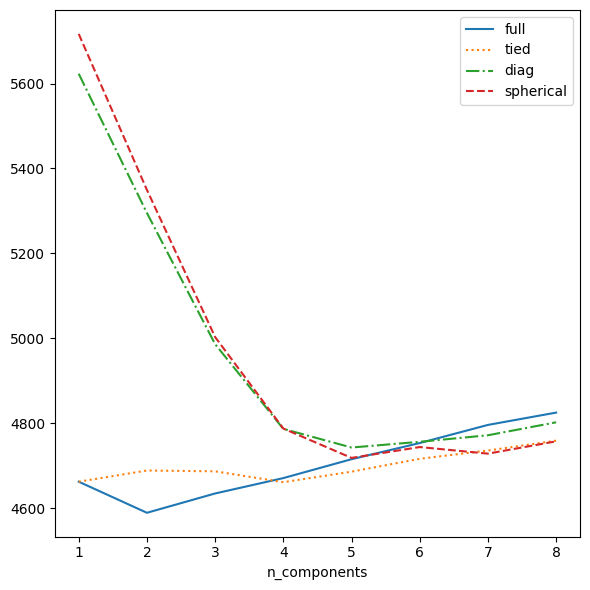

In [71]:
results = []                                              # Initialize an empty list to store results for each GMM configuration
covariance_types = ['full', 'tied', 'diag', 'spherical']  # List of different covariance types for GMM

# Loop through different numbers of components (from 1 to 8)
for n_components in range(1, 9):
    
    # Loop through each covariance type
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components=n_components,       # Define GMM with the current number of components
                                 warm_start=True,                 # Use previous fit to initialize the next iteration
                                 covariance_type=covariance_type  # Set covariance type
                                )
        mclust.fit(df)                           # Fit the GMM to the data
        results.append({                         # Append the BIC and other details to results
            'bic': mclust.bic(df),               # Calculate Bayesian Information Criterion (BIC)
            'n_components': n_components,        # Number of components used in the model
            'covariance_type': covariance_type,  # Covariance type used in the model
        })

# Convert the results list to a DataFrame for easy analysis
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']        # Define a list of colors for plotting (optional)
styles = ['C0-', 'C1:', 'C2-.', 'C3--']  # Define line styles for different covariance types

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through each covariance type to plot BIC results
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]  # Filter results by covariance type
    subset.plot(x='n_components',       # Plot the number of components on the x-axis
                y='bic',                # Plot BIC values on the y-axis
                ax=ax,                  # Use the existing axis for the plot
                label=covariance_type,  # Label the line with the covariance type
                kind='line',            # Specify the kind of plot
                style=styles[i])        # Use the defined line style for this covariance type

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()          # Display the plot

*This indicates that full covariance is the best choice for modeling the data with 2 components.*

In [73]:
from sklearn.mixture import GaussianMixture

# Define and fit the GMM model with full covariance type and n_components = 2
gmm_full = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

# Fit the model to your data
gmm_full.fit(df)

# Calculate and return the Bayesian Information Criterion (BIC) for the model on the dataset
gmm_full.bic(df)  

4589.820626249873

# Scaling and Categorical Variables
Unsupervised learning techniques generally require that the data be appropriatelyscaled. 
### Scaling the Variables

In [75]:
# Load the CSV data into a DataFrame
url1 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan_data.csv')  
loan_data = pd.read_csv(url1)

loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [76]:
# Set the 'outcome' column as a categorical type, with ordered categories 'paid off' and 'default'
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

# Filter the dataset to only include rows where 'outcome' is 'default'
defaults = loan_data.loc[loan_data['outcome'] == 'default']

# Select specific columns for clustering analysis
columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 'dti', 'revol_util']
df = defaults[columns]

# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, 
                random_state=1, 
                n_init='auto').fit(df)

# Count the number of data points in each cluster
counts = Counter(kmeans.labels_)

# Create a DataFrame for the cluster centers with the selected columns
centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)

# Add a column for the size of each cluster, based on the counts calculated
centers['size'] = [counts[i] for i in range(4)]

# Display the DataFrame containing the cluster centers and sizes
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,17809.760881,78669.452556,18933.405997,11.594003,17.016428,62.183810,7906
1,21444.318867,148736.057263,33152.689572,12.376733,13.831145,63.151084,1654
2,24290.909091,409746.465909,84710.988636,13.431818,8.148636,60.015647,88
3,10274.160906,41241.205530,9950.095008,9.480338,17.718588,57.903425,13023


### Normalization

In [78]:
# Initialize a StandardScaler object for normalizing the data
scaler = preprocessing.StandardScaler()

# Scale the data in df to have mean 0 and standard deviation 1 (converting it to float if needed)
df0 = scaler.fit_transform(df * 1.0)

# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)

# Count the number of data points in each cluster
counts = Counter(kmeans.labels_)

# Create a DataFrame for the cluster centers and transform them back to the original scale
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=columns)

# Add a column for the size of each cluster, based on the counts calculated
centers['size'] = [counts[i] for i in range(4)]

# Display the DataFrame containing the cluster centers and sizes
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,13484.728906,55907.993263,16435.803337,14.322265,24.211535,59.463608,6244
1,25950.205142,116834.142232,32945.972921,12.396335,16.165914,66.123542,3670
2,10507.283093,51117.994063,11635.285252,7.509513,15.931561,77.795077,7397
3,10324.846369,53456.824767,6054.819926,8.664618,11.312983,30.999874,5360


The cluster sizes are more balanced, and the clusters are not dominated by
annual_inc and revol_bal, revealing more interesting structure in the data. Note
that the centers are rescaled to the original units in the preceding code. If we had left
them unscaled, the resulting values would be in terms of z-scores and would there‐
fore be less interpretable.

Scaling is also important for PCA. Using the z-scores is equivalentto using the correlation matrix instead of the covariance matrix in computing the principal components. 

## Dominant Variables
Even in cases where the variables are measured on the same scale and accurately
reflect relative importance (e.g., movement to stock prices), it can sometimes be useful to rescale the variables.

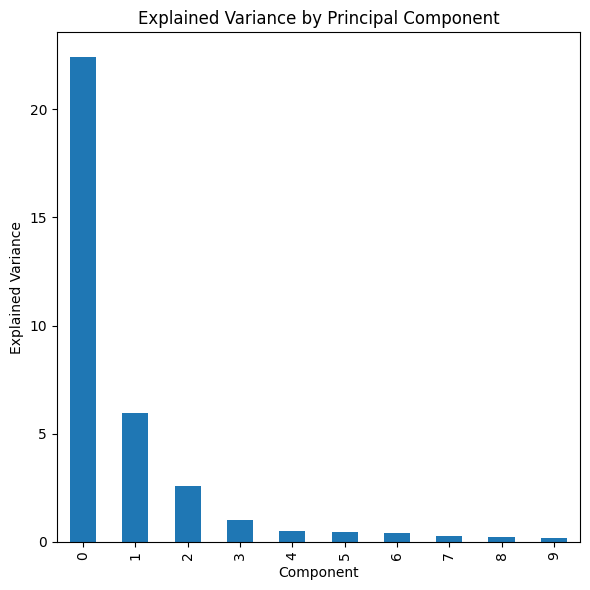

In [81]:
# Define the stock symbols that we are interested in
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']

# Extract data for selected stocks starting from 2005 onwards
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

# Initialize a Principal Component Analysis (PCA) model
sp_pca1 = PCA()

# Fit the PCA model on the extracted data
sp_pca1.fit(top_sp1)

# Create a DataFrame of the explained variance for each principal component
explained_variance = pd.DataFrame(sp_pca1.explained_variance_)

# Plot the explained variance of the first 10 principal components as a bar chart
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(6, 6))

ax.set_xlabel('Component')                                 # Set the x-axis label
ax.set_ylabel('Explained Variance')                        # Set the y-axis label
ax.set_title('Explained Variance by Principal Component')  # Set the title of the plot

plt.tight_layout() # Adjust the layout
plt.show()         # Display the plot

In [82]:
# Rename column 0 to 'explain_var'
explained_variance.rename(columns={0: 'explain_var'}, inplace=True)

# Calculate the total variance
total_var = explained_variance['explain_var'].sum()

# Calculate the percentage of variance explained by each component
explained_variance['percentage'] = explained_variance['explain_var'] / total_var

# Calculate the cumulative percentage
explained_variance['cumulative_%'] = explained_variance['percentage'].cumsum()

# Display the updated DataFrame
explained_variance

,explain_var,percentage,cumulative_%
0,22.435315,0.647172,0.647172
1,5.953799,0.171744,0.818916
2,2.565854,0.074015,0.892931
3,1.018005,0.029365,0.922296
4,0.516935,0.014912,0.937208
5,0.442138,0.012754,0.949962
6,0.388707,0.011213,0.961174
7,0.254585,0.007344,0.968518
8,0.210319,0.006067,0.974585
9,0.174569,0.005036,0.979621


In [83]:
# Create a DataFrame for the loadings of the first two principal components
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)

# Transpose the loadings DataFrame to better understand the contribution of each stock to the components
loadings.transpose()

,0,1
GOOGL,0.857310,-0.477873
AMZN,0.444728,0.874149
AAPL,0.071627,0.020802
MSFT,0.036002,0.006204
CSCO,0.029205,0.003045
INTC,0.026666,0.006069
CVX,0.089548,0.037420
XOM,0.080336,0.020511
SLB,0.110218,0.030356
COP,0.057739,0.024117


The first two principal components are almost completely dominated by GOOGL and AMZN. This is because the stock price movements of GOOGL and AMZN dominate the variability.

To handle this situation, you can either include them as is, **rescale the variables**, or **exclude the dominant variables from the analysis and handle them separately**. There is no “correct” approach, and the treatment depends on the application.

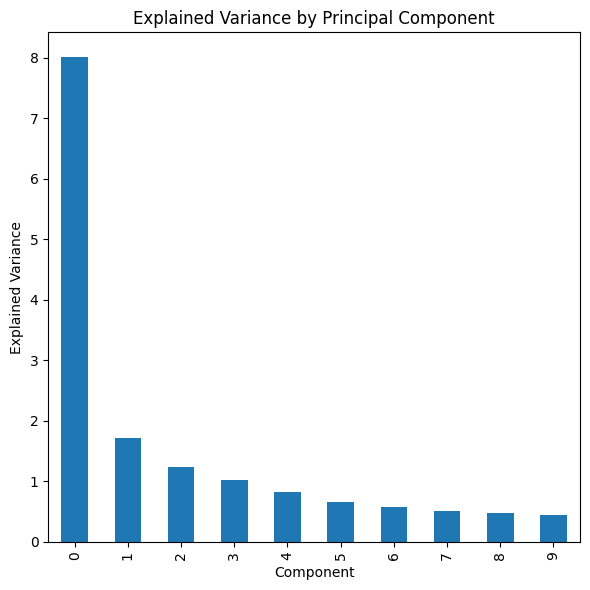

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Symbols of interest
syms1 = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
         'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']

# Extract the data from 2005 onwards for the selected symbols
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms1]

# Standardize the data using StandardScaler
scaler = StandardScaler()
top_sp1_scaled = scaler.fit_transform(top_sp1)

# Apply PCA on the scaled data
sp_pca1 = PCA()
sp_pca1.fit(top_sp1_scaled)

# Plot explained variance
explained_variance = pd.DataFrame(sp_pca1.explained_variance_)

ax = explained_variance.head(10).plot.bar(legend=False, figsize=(6, 6))
ax.set_xlabel('Component')
ax.set_ylabel('Explained Variance')  # Add Y-axis label
ax.set_title('Explained Variance by Principal Component')  # Add title

plt.tight_layout()
plt.show()

In [86]:
# Rename column 0 to 'explain_var'
explained_variance.rename(columns={0: 'explain_var'}, inplace=True)

# Calculate the total variance
total_var = explained_variance['explain_var'].sum()

# Calculate the percentage of variance explained by each component
explained_variance['percentage'] = explained_variance['explain_var'] / total_var

# Calculate the cumulative percentage
explained_variance['cumulative_%'] = explained_variance['percentage'].cumsum()

# Display the updated DataFrame
explained_variance

,explain_var,percentage,cumulative_%
0,8.022906,0.445548,0.445548
1,1.725066,0.095801,0.541349
2,1.234896,0.068579,0.609928
3,1.017783,0.056522,0.666450
4,0.822300,0.045666,0.712117
5,0.660991,0.036708,0.748824
6,0.575881,0.031981,0.780806
7,0.513622,0.028524,0.809329
8,0.481659,0.026749,0.836078
9,0.444945,0.024710,0.860788


In [87]:
# Create a DataFrame for the loadings of the first two principal components
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)

# Transpose the loadings DataFrame to better understand the contribution of each stock to the components
loadings.transpose()

,0,1
GOOGL,0.220376,-0.043901
AMZN,0.186224,-0.044513
AAPL,0.176025,-0.032181
MSFT,0.236321,-0.007349
CSCO,0.251647,-0.033820
INTC,0.236678,-0.037802
CVX,0.252598,0.418393
XOM,0.256584,0.379210
SLB,0.216233,0.413399
COP,0.232247,0.457359


# Categorical Data and Gower’s Distance
In the case of categorical data, you must convert it to numeric data, either by ranking
(for an ordered factor) or by encoding as a set of binary (dummy) variables. If the
data consists of mixed continuous and binary variables, you will usually want to scale
the variables so that the ranges are similar.
One popular method is to use **Gower’s Distance**.

The basic idea behind Gower’s distance is to apply a different distance metric to each
variable depending on the type of data:

    • For numeric variables and ordered factors, distance is calculated as the absolute value of the difference between two records (Manhattan distance).

    • For categorical variables, the distance is 1 if the categories between two records are different, and the distance is 0 if the categories are the same.

In [89]:
# Example with categorical data & numeric data
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
x

,dti,payment_inc_ratio,home_,purpose_
0,1.00,2.39320,RENT,major_purchase
1,5.55,4.57170,OWN,small_business
2,18.08,9.71600,RENT,other
3,10.08,12.21520,RENT,debt_consolidation
4,7.06,3.90888,RENT,other


## Problems with Clustering Mixed Data

K-means and PCA are most appropriate for continuous variables. For smaller data sets, it is better to use hierarchical clustering with Gower’s distance. In principle, there is no reason why K-means can’t be applied to binary or categorical data. You would usually use the “one hot encoder” representation to convert the categorical data to numeric values. In practice, however, using K-means and PCA with binary data can be difficult.

In [92]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']

dfo = defaults[columns]

dfo.head()

,dti,payment_inc_ratio,home_,pub_rec_zero
0,1.00,2.39320,RENT,1
1,5.55,4.57170,OWN,1
2,18.08,9.71600,RENT,1
3,10.08,12.21520,RENT,1
4,7.06,3.90888,RENT,1


In [93]:
dfo['home_'].unique()

array(['RENT', 'OWN', 'MORTGAGE'], dtype=object)

In [94]:
dfo['pub_rec_zero'].unique()

array([1, 0], dtype=int64)

If the standard z-scores are used, the binary variables will dominate the definition of
the clusters. This is because 0/1 variables take on only two values, and K-means can
obtain a small within-cluster sum-of-squares by assigning all the records with a 0 or 1
to a single cluster.

**The solution is to normalize the data using z-scores, which brings all variables to the same scale, making the clustering more balanced.**

In [97]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']  # Define the columns to be used for clustering

df = pd.get_dummies(defaults[columns])                           # Convert categorical features into dummy variables

scaler = preprocessing.StandardScaler()                          # Initialize the StandardScaler for normalizing features

df0 = scaler.fit_transform(df * 1.0)                             # Standardize the data (mean = 0, variance = 1) for consistent scaling

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)  # Perform KMeans clustering on the standardized data

# Transform cluster centers back to the original scale and convert to a DataFrame
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df.columns)

centers        # Display the cluster centers

,dti,payment_inc_ratio,pub_rec_zero,home__MORTGAGE,home__OWN,home__RENT
0,21.431365,12.354001,0.943315,-1.942890e-15,4.718448e-16,1.000000e+00
1,12.743276,5.918701,0.900372,-1.276756e-15,1.526557e-16,1.000000e+00
2,17.339786,8.353535,0.905716,1.000000e+00,-5.273559e-16,-4.163336e-15
3,17.197993,9.266666,0.917903,1.054712e-15,1.000000e+00,-2.775558e-16


The top four clusters are essentially proxies for the different levels of the factor variables. To avoid this behavior, you could scale the binary variables to have a smaller variance than other variables. Alternatively, for very large data sets, you could apply clustering to different subsets of data taking on specific categorical values. For example, you could apply clustering separately to those loans made to someone who has a
mortgage, owns a home outright, or rents.